#Import libraries

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [6]:
# Make transforms and use data loaders

# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [7]:
# Set the directory for the data
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Covid-19 image classification/Covid19-dataset'

# Use the image folder function to create datasets
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
  chosen_transforms[x])
                  for x in ['train', 'test']}

In [8]:
chosen_datasets

{'test': Dataset ImageFolder
     Number of datapoints: 66
     Root location: /content/drive/MyDrive/Colab Notebooks/Deep Learning/Covid-19 image classification/Covid19-dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'train': Dataset ImageFolder
     Number of datapoints: 251
     Root location: /content/drive/MyDrive/Colab Notebooks/Deep Learning/Covid-19 image classification/Covid19-dataset/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.

In [9]:
# Make iterables with the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4,
  shuffle=True, num_workers=4)
              for x in ['train', 'test']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'test']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


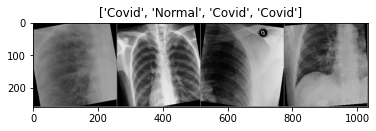

In [12]:
# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Setting up a Pretrained Model

In [13]:
# load in pretrained and reset final fully connected

res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [14]:
res_mod

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [19]:
 model = train_model(model = res_mod, criterion = criterion, optimizer = optimizer_ft, scheduler = exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7928 Acc: 0.6414
Iterating through data...
test Loss: 0.2211 Acc: 0.9545

Epoch 1/9
----------
Iterating through data...
train Loss: 0.6095 Acc: 0.7291
Iterating through data...
test Loss: 0.5751 Acc: 0.7727

Epoch 2/9
----------
Iterating through data...
train Loss: 0.8221 Acc: 0.7450
Iterating through data...
test Loss: 0.3416 Acc: 0.8939

Epoch 3/9
----------
Iterating through data...
train Loss: 0.6255 Acc: 0.7570
Iterating through data...
test Loss: 0.6044 Acc: 0.8030

Epoch 4/9
----------
Iterating through data...
train Loss: 0.7544 Acc: 0.7530
Iterating through data...
test Loss: 0.1948 Acc: 0.9394

Epoch 5/9
----------
Iterating through data...
train Loss: 0.5939 Acc: 0.7610
Iterating through data...
test Loss: 0.1476 Acc: 0.9545

Epoch 6/9
----------
Iterating through data...
train Loss: 0.4136 Acc: 0.8287
Iterating through data...
test Loss: 0.1012 Acc: 0.9697

Epoch 7/9
----------
Iterating through data...
train Loss: 0.3857 Acc: 0.8606
Iterating through data..

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


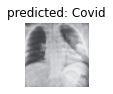

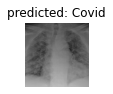

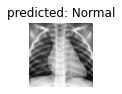

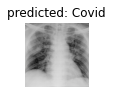

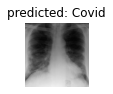

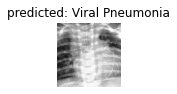

In [23]:
visualize_model(model)
plt.show()

In [24]:
import torch
torch.save(model, 'model.pth')